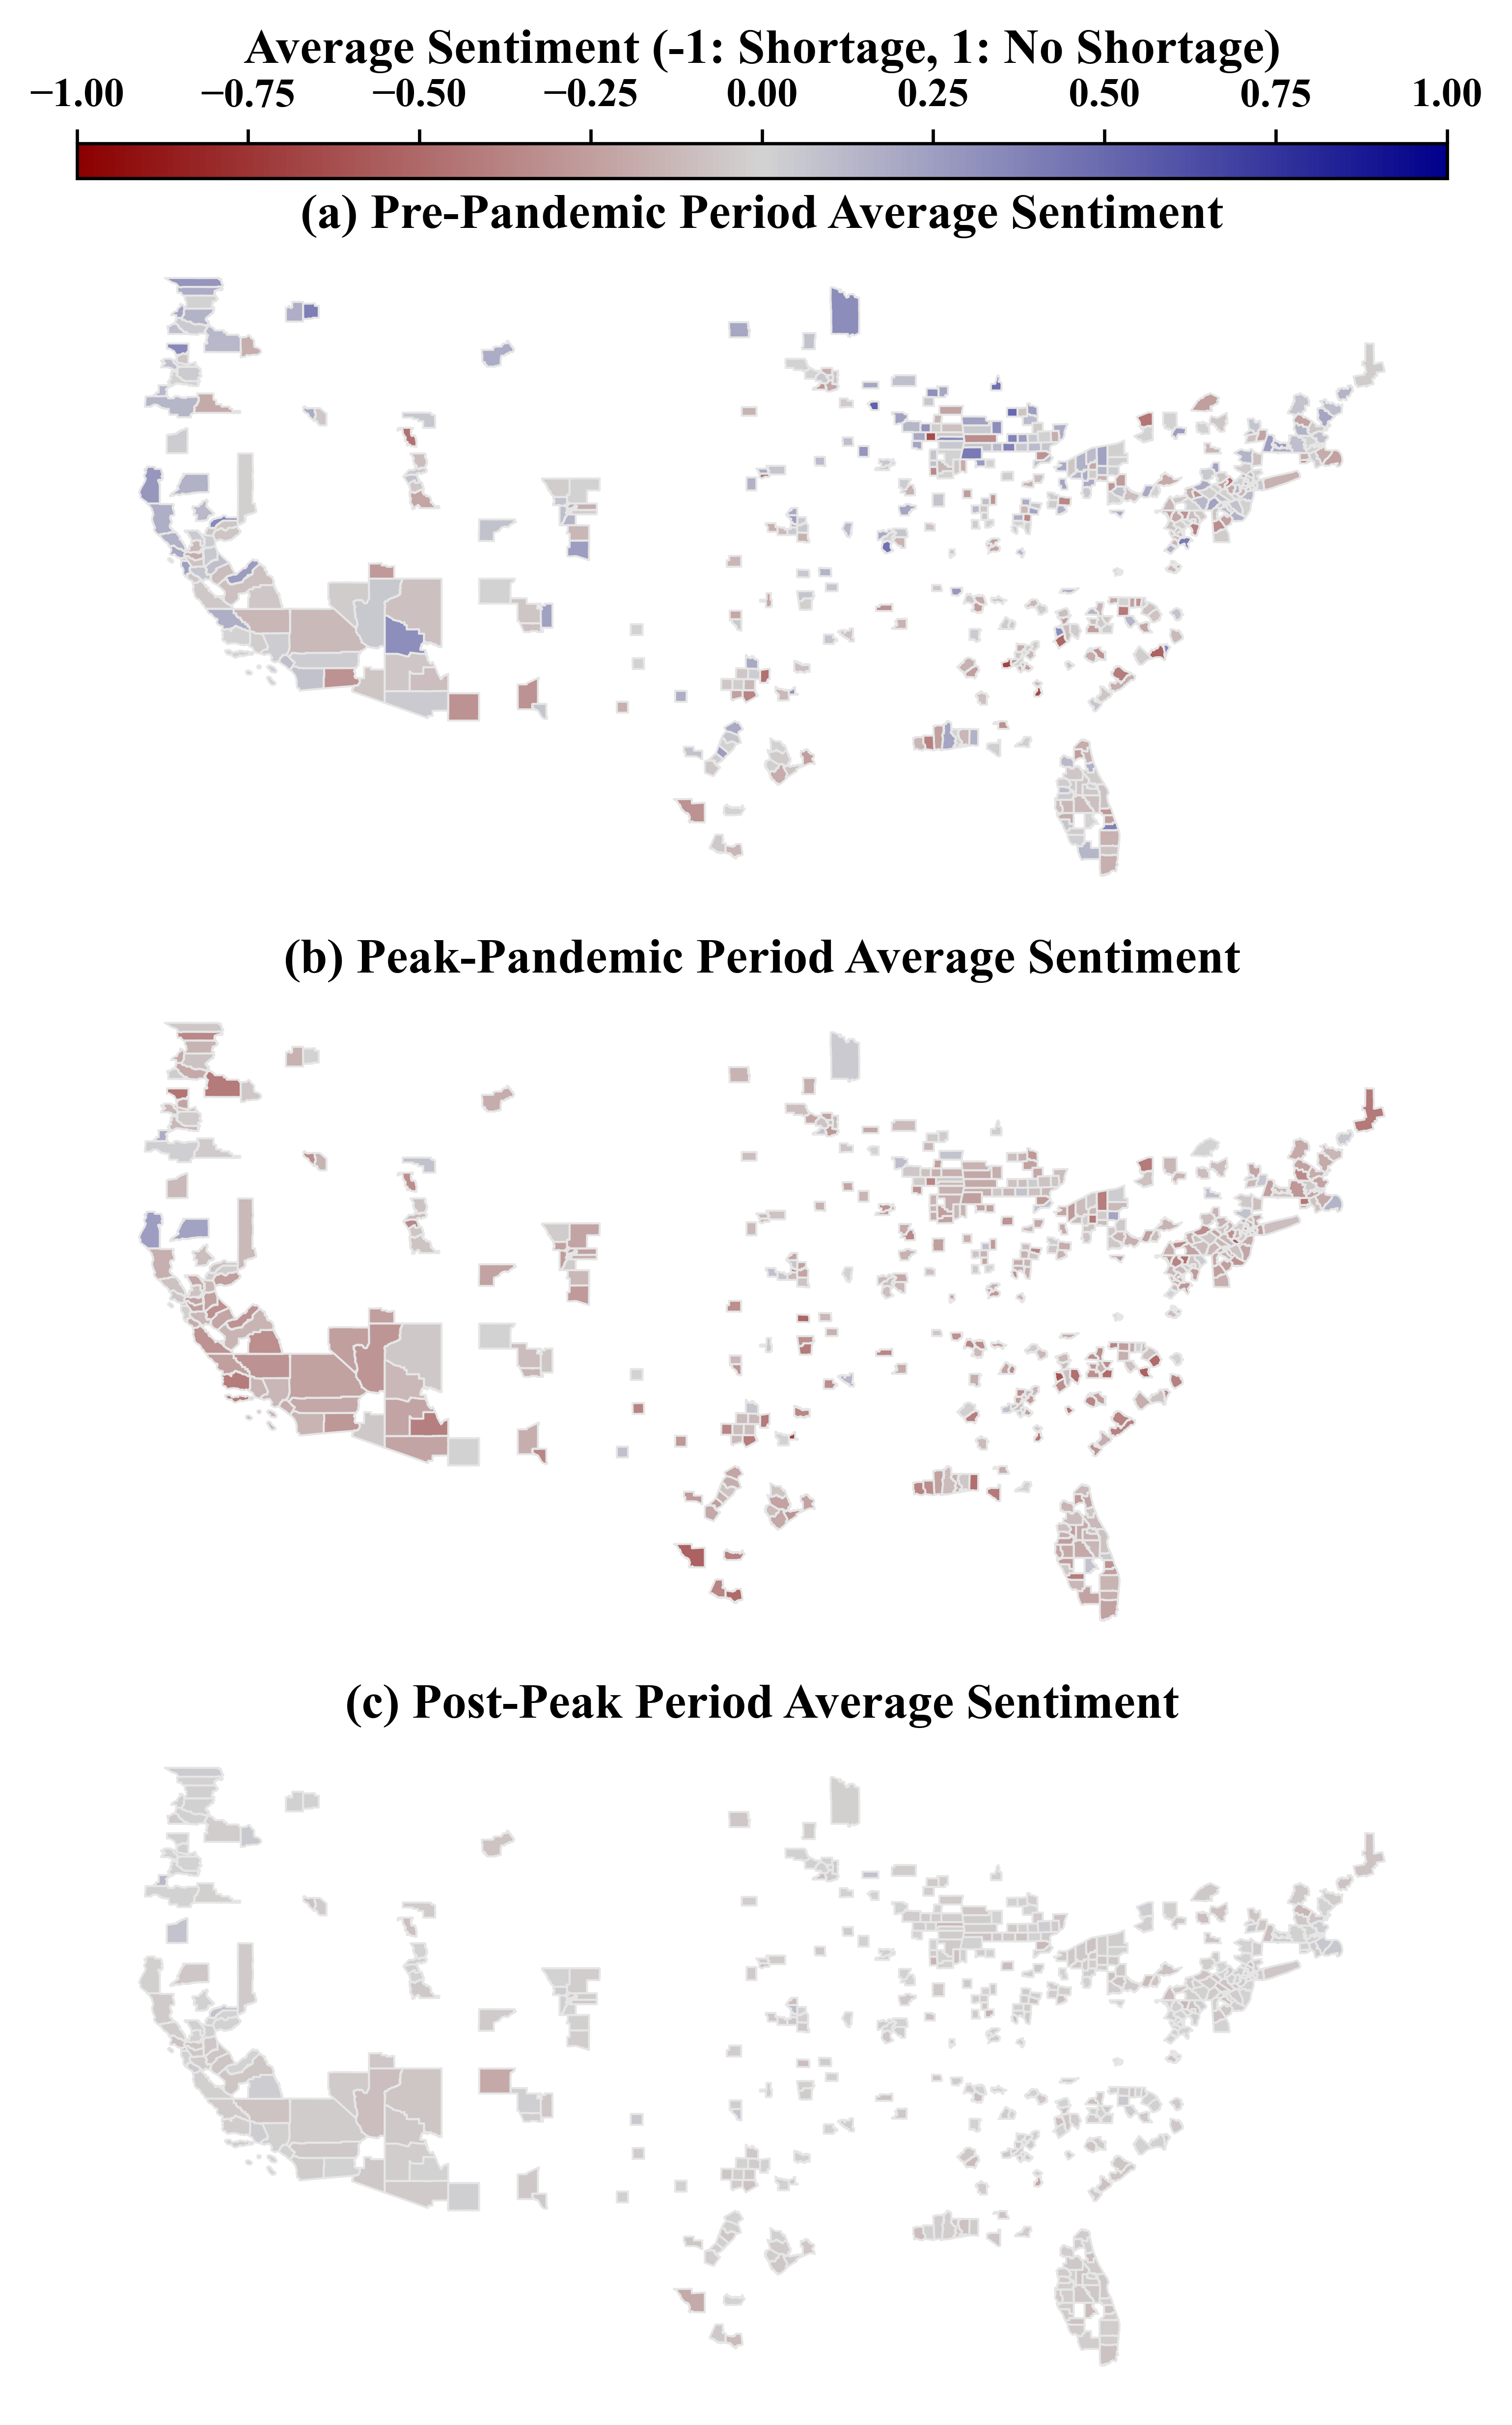

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.font_manager import FontProperties

# Set global font properties
font_props = FontProperties(family='Times New Roman', weight='bold')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

# Define a more vibrant and smoother red-gray-blue gradient
cmap = LinearSegmentedColormap.from_list(
    'enhanced_red_gray_blue',
    ['#8B0000', '#D3D3D3', '#00008B']  # Dark red -> light gray -> dark blue
)

# Read CSV file
df = pd.read_csv('gis_plot_data.csv')
df = df[
    (df['Pre-COVID_review_count'] > 10) &
    (df['During-COVID_review_count'] > 10) &
    (df['Post-COVID_review_count'] > 10)
]

# Remove 'County' suffix and extra spaces
df['County_Name'] = df['County_Name'].str.replace(' County', '', regex=False).str.strip()
df['State_Name'] = df['State_Name'].str.strip()

# Convert county and state names to uppercase for matching
df['County_Name'] = df['County_Name'].str.upper()
df['State_Name'] = df['State_Name'].str.upper()

# Read US county-level administrative boundary shapefile
counties_gdf = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2018/COUNTY/tl_2018_us_county.zip')

# Read US state-level administrative boundary shapefile
states_gdf = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2018/STATE/tl_2018_us_state.zip')

# Merge state names into county-level data
counties_gdf = counties_gdf.merge(
    states_gdf[['STATEFP', 'NAME']], 
    on='STATEFP', 
    how='left',
    suffixes=('', '_state')
)

# Rename columns to match
counties_gdf = counties_gdf.rename(columns={'NAME': 'County_Name', 'NAME_state': 'State_Name'})

# Convert county and state names to uppercase for matching
counties_gdf['County_Name'] = counties_gdf['County_Name'].str.upper()
counties_gdf['State_Name'] = counties_gdf['State_Name'].str.upper()

# Merge shapefile with sentiment data
merged_gdf = counties_gdf.merge(df, on=['State_Name', 'County_Name'], how='left')

# Create figure with adjusted spacing
# fig = plt.figure(figsize=(6, 10))  # Increased figure height
fig = plt.figure(figsize=(6, 10), dpi=600) 

# Create GridSpec for better control over subplot spacing
gs = fig.add_gridspec(4, 1, height_ratios=[0.05, 1, 1, 1], hspace=0.1)

# Add colorbar in the first row
cbar_ax = fig.add_subplot(gs[0])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Sentiment (-1: Shortage, 1: No Shortage)', fontsize=12, color='black', weight='bold')
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')

# Create the three maps
periods = [
    ('Pre-COVID_average_sentiment', '(a) Pre-Pandemic Period Average Sentiment'),
    ('During-COVID_average_sentiment', '(b) Peak-Pandemic Period Average Sentiment'),
    ('Post-COVID_average_sentiment', '(c) Post-Peak Period Average Sentiment')
]

for idx, (column, title) in enumerate(periods):
    ax = fig.add_subplot(gs[idx + 1])
    merged_gdf.plot(
        column=column,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        linewidth=0.5,
        ax=ax,
        edgecolor='0.9'
    )
    ax.set_title(title, fontsize=12, fontweight='bold', pad=5, color='black')
    ax.axis('off')

# Adjust layout
plt.savefig('GIS.png', 
            format='png',
            bbox_inches='tight',
            dpi=600,
            transparent=False,
            facecolor='white',
            pad_inches=0.1)
plt.show()

In [29]:
import pandas as pd
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran
import geopandas as gpd
from shapely.geometry import Point

# Create a mock geometry for spatial weights
n_counties = len(df)
grid_size = int(np.ceil(np.sqrt(n_counties)))
x_coords = np.repeat(range(grid_size), grid_size)[:n_counties]
y_coords = np.tile(range(grid_size), grid_size)[:n_counties]

# Create points geometry
geometry = [Point(x, y) for x, y in zip(x_coords, y_coords)]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Create spatial weights matrix using Queen contiguity
w = Queen.from_dataframe(gdf)
w.transform = 'r'  # Row-standardize weights

# Calculate Moran's I for each period
periods = {
    'Pre-Pandemic Period': 'Pre-COVID_average_sentiment',
    'Peak-Pandemic Period': 'During-COVID_average_sentiment',
    'Post-Peak Period': 'Post-COVID_average_sentiment'
}

# Store results
results = {}

for period, column in periods.items():
    # Remove missing values
    valid_data = gdf[~gdf[column].isna()]
    if len(valid_data) > 0:
        w_valid = Queen.from_dataframe(valid_data)
        w_valid.transform = 'r'
        
        moran = Moran(valid_data[column], w_valid)
        results[period] = {
            'morans_i': moran.I,
            'p_value': moran.p_sim,
            'z_score': moran.z_sim
        }

# Print results
print("\nSpatial Autocorrelation Analysis Results:")
print("-" * 50)
for period, stats in results.items():
    print(f"\n{period} Period:")
    print(f"Moran's I: {stats['morans_i']:.3f}")
    print(f"p-value: {stats['p_value']:.3f}")
    print(f"z-score: {stats['z_score']:.3f}")

/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_12454/3939649659.py:19: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_12454/3939649659.py:36: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_valid = Queen.from_dataframe(valid_data)
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_12454/3939649659.py:36: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_valid = Queen.from_dataframe(valid_data)
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_12454/3939649659.py:36: FutureWarning: `use_index` defaults to False but will default to True in future. 


Spatial Autocorrelation Analysis Results:
--------------------------------------------------

Pre-Pandemic Period Period:
Moran's I: 0.001
p-value: 0.425
z-score: 0.147

Peak-Pandemic Period Period:
Moran's I: 0.016
p-value: 0.061
z-score: 1.627

Post-Peak Period Period:
Moran's I: 0.022
p-value: 0.014
z-score: 2.311


/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_38919/2506693963.py:29: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_38919/2506693963.py:38: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_valid = Queen.from_dataframe(valid_data)
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_38919/2506693963.py:38: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_valid = Queen.from_dataframe(valid_data)
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_38919/2506693963.py:38: FutureWarning: `use_index` defaults to False but will default to True in future. 

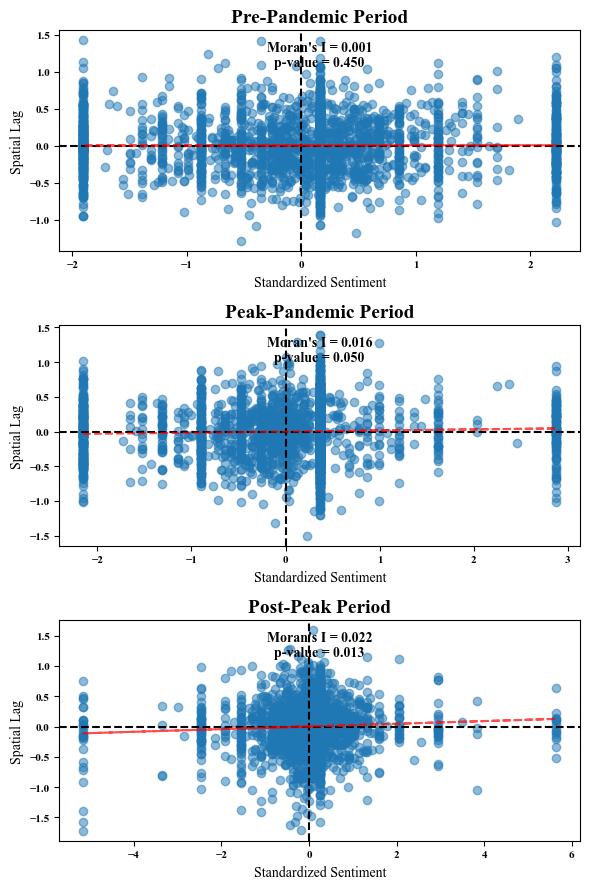

In [3]:
import pandas as pd
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Set global font properties
font_props = FontProperties(family='Times New Roman', weight='bold')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

df = pd.read_csv('gis_plot_data.csv')
df = df[
    (df['Pre-COVID_review_count'] > 10) &
    (df['During-COVID_review_count'] > 10) &
    (df['Post-COVID_review_count'] > 10)
]

n_counties = len(df)
grid_size = int(np.ceil(np.sqrt(n_counties)))
x_coords = np.repeat(range(grid_size), grid_size)[:n_counties]
y_coords = np.tile(range(grid_size), grid_size)[:n_counties]
geometry = [Point(x, y) for x, y in zip(x_coords, y_coords)]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

w = Queen.from_dataframe(gdf)
w.transform = 'r'

fig, axes = plt.subplots(3, 1, figsize=(6, 9))  # 调整尺寸以适应 ACM 模板
periods = ['Pre-Pandemic Period', 'Peak-Pandemic Period', 'Post-Peak Period']
columns = ['Pre-COVID_average_sentiment', 'During-COVID_average_sentiment', 'Post-COVID_average_sentiment']

for idx, (period, column) in enumerate(zip(periods, columns)):
    valid_data = gdf[~gdf[column].isna()]
    w_valid = Queen.from_dataframe(valid_data)
    w_valid.transform = 'r'
    moran = Moran(valid_data[column], w_valid)
    
    z_score = (valid_data[column] - valid_data[column].mean()) / valid_data[column].std()
    moran_lag = w_valid.sparse.dot(z_score)
    
    axes[idx].scatter(z_score, moran_lag, alpha=0.5)  # 添加 color='black'
    axes[idx].axhline(y=0, color='black', linestyle='--')
    axes[idx].axvline(x=0, color='black', linestyle='--')
    
    z = np.polyfit(z_score, moran_lag, 1)
    p = np.poly1d(z)
    axes[idx].plot(z_score, p(z_score), 'r--', alpha=0.7)
    
    axes[idx].set_xlabel('Standardized Sentiment', fontsize=10, color='black')
    axes[idx].set_ylabel('Spatial Lag', fontsize=10, color='black')
    axes[idx].set_title(period, fontsize=14, fontweight='bold', color='black')
    
    axes[idx].text(0.5, 0.95, 
                   f"Moran's I = {moran.I:.3f}\np-value = {moran.p_sim:.3f}",
                   horizontalalignment='center',
                   verticalalignment='top',
                   transform=axes[idx].transAxes,
                   fontsize=10,
                   fontweight='bold',
                   color='black')  
    
    axes[idx].tick_params(labelsize=8, colors='black')
    
    axes[idx].spines['bottom'].set_color('black')
    axes[idx].spines['top'].set_color('black')
    axes[idx].spines['right'].set_color('black')
    axes[idx].spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('moran_scatterplots.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()